# Outlier removal

Load the `mean_data` dictionary created in [imputing_data](imputing_data.ipynb), and `all_keys` feature list created in [email_features](email_features.ipynb):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tools.feature_format import featureFormat
import os

HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')
dict_path = os.path.join(DATA_PATH, 'mean_data.pkl')
keys_path = os.path.join(DATA_PATH, 'all_keys.pkl')

with open(dict_path, 'rb') as f:
    mean_data = pickle.load(f)

with open(keys_path, 'rb') as f:
    all_keys = pickle.load(f)

In [2]:
# Start with all features except: 'email_address'
all_keys.remove('email_address')

data = featureFormat(mean_data, all_keys, sort_keys=True, keep_keys=True)
keys, labels, features = data[:,0], data[:,1].astype(float), data[:, 2:].astype(float)
keys.shape, labels.shape, features.shape

((149,), (149,), (149, 4231))

In [3]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(features)
scores = clf.decision_function(features)

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


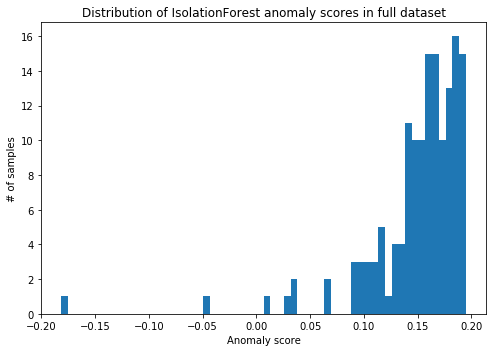

In [4]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
ax = fig.gca()
ax.hist(scores, bins=60)
ax.set_title('Distribution of IsolationForest anomaly scores in full dataset')
ax.set_xlabel('Anomaly score')
ax.set_ylabel('# of samples')
plt.show()

In [17]:
outlier_mask = scores < 0.065
outlier_features, outlier_labels, outlier_keys =\
features[outlier_mask], labels[outlier_mask], keys[outlier_mask]
print 'Number of outliers: ', len(outlier_labels)
print 'Outliers that are pois: ', int(sum(outlier_labels))

Number of outliers:  6
Outliers that are pois:  4


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
arr = pca.fit_transform(features)

plt_dict = {'title': 'outlier removal'}
plt_dict['array'] = arr
plt_dict['masks'] = {}
plt_dict['masks']['poi'] = {'array': (labels == 1),
                            'kwargs': {'facecolors':'none', 
                                       'edgecolors':'b',
                                       'label':'poi'}}
plt_dict['masks']['non_poi'] = {'array': (labels == 0),
                                'kwargs': {'facecolors':'none', 
                                            'edgecolors':'r',
                                            's':5,
                                            'label':'non_poi'}}
plt_dict['masks']['outliers'] = {'array': outlier_mask,
                                 'kwargs': {'color':'k',
                                            'marker':'x',
                                            's':80,
                                            'label':'outliers'}}

In [20]:
def scatter_plotter(dict_list, rows_columns=(1,1), figsize=(7, 7)):
    """
    Takes a list of dicts and plots each.
    
    dicts should contain the following:
    'array': X, y array to be plotted
    'title': title for the array
    'masks': dicts with
                -'mask': bool index to apply
                -'kwargs': keyword arguments to apply to the mask 
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i, dicty in enumerate(dict_list):
        X = dicty['array'][:,0]
        y = dicty['array'][:,1]
        ax = fig.add_subplot(r, c, i+1)
        for key, mask in dicty['masks'].items():
            idx = mask['array']
            kwargs = mask['kwargs']
            ax.scatter(X[idx],
                       y[idx], 
                       **kwargs)
        
        title = dicty.get('title', '')
        ax.set_title(title)
        ax.legend()
    plt.show()

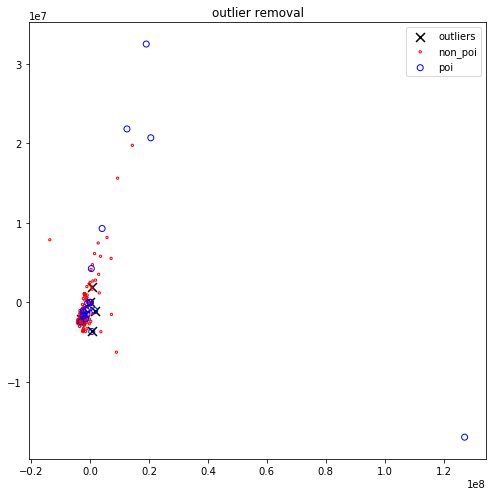

In [21]:
scatter_plotter([plt_dict])

In [22]:
for key in outlier_keys:
    print key

BELDEN TIMOTHY N
CALGER CHRISTOPHER F
DELAINEY DAVID W
FORNEY M
KAMINSKI WINCENTY J
KEAN STEVEN J


In [24]:
out_data = mean_data.copy()
for key in outlier_keys:
    del out_data[key]

In [25]:
out_path = os.path.join(DATA_PATH, 'out_data.pkl')
with open(out_path, 'wb') as f:
    pickle.dump(out_data, f)